In [168]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from tabulate import tabulate

#Definining a function to make units easier:
def SI(l, units):
    SI_I = (l * units).decompose()
    return SI_I.value

#Constants:
T_test = 5730.97 #Kelvin
P_test = 1.2594 #log(P)
T_test_vega = 6744.1
P_test_vega = -0.027889772
B = 0.1 #ratio of the #He/#H
A = 10**4 #ratio of #H/#metal
sigma_t = 6.655*10**(-25) #cm^2 -- thompson
m_h = 1.6726219*10**(-24) #grams -- mass of ionized hydrogen, eg. a proton
c = SI(29979245800, u.cm/u.s) #cm / s -- speed of light 
h = 6.62606896*10**(-27) #ergs * s -- Planck's constant
k = 1.38065*10**(-16) #ergs / Kelvin -- Boltzmann constant
Chi = 2.195*10**(-11) #ergs -- ionization energy of hydrogen

#Constants for the sun-like star:
L = SI(5000, u.AA) #angstroms
l = ((L*u.m).to(u.micron)).value #microns
v = c/(L) # s^-1 -- frequency associated with L

#Constants for Vega:
L_vega = SI(7000, u.AA) #angstroms -- I will consider this wavelength for Vega
l_vega = ((L_vega*u.m).to(u.micron)).value
v_vega = c/(L_vega)

#input data - sun-like star:
check_ans = np.genfromtxt('opacities.dat', dtype='f8', names = ['temp', 'log_P', 'logH', 'logHminus', 'logsigma'])
temp_pelog_dat = np.genfromtxt('temp_pelog.dat', dtype='f8', names = ['temp','log_P' ])
temp = check_ans['temp']
pe_log = check_ans['log_P']

#ANSWERS for sun-like star opacities
check_H = check_ans['logH']
check_Hminus = check_ans['logHminus']
check_sigma = check_ans['logsigma']

#input data - vega:
opacities_vega = np.genfromtxt('vega-atmos-grid.dat', dtype='f8', names = ['temp', 'P'])
temp_vega = opacities_vega['temp']
p_vega = opacities_vega['P']


In [169]:
#Defining theta:
def Theta(T):
    theta = 5040./T
    return theta

#Defining the Saha equation for hydrogen. Returns the ratio of n/n:
def Saha_H(T, P):
    Saha_H_ans =  (5.0/2.0)*np.log10(T) - 13.595*(Theta(T)) - P - 0.4772
    return 10**Saha_H_ans

#Defining the Saha equation for metals. Returns the ratio of n/n:
def Saha_metals(T, P):
    Saha_metals_ans = (5.0/2.0)*np.log10(T) - 7.9*(Theta(T)) - P - 0.0971
    return 10**Saha_metals_ans

#Defining X = fraction of H ionized:
def X(H_ratio):
    X_ans = H_ratio / (1 + H_ratio)
    return X_ans

#Defining Y = faction of metal ionized: 
def Y(m_ratio):
    Y_ans = m_ratio / (1 + m_ratio)
    return Y_ans

#Sun - H/m_ratio for X and Y:
H_ratio = Saha_H(temp, pe_log)
m_ratio = Saha_metals(temp, pe_log)

#Vega - H/m_ratio for X and Y:
H_ratio_vega = Saha_H(temp_vega, p_vega)
m_ratio_vega = Saha_metals(temp_vega, p_vega)

In [170]:
#Defining Gaunt free-free factor:
def Gaunt_ff(T,l):
    Gaunt_ff_ans = 1.084 + 0.0188/Theta(T) + (0.00161 + (0.02661/Theta(T)))*l - (0.0192 - (0.03889/Theta(T)) + (0.02833/((Theta(T))**2)) - (0.007828/((Theta(T))**3)) + (0.0007304/((Theta(T))**4)))*(l**2)
    return Gaunt_ff_ans

#Defining coefficients for a, b, c for the Gaunt bound-free factor:
m = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
a_m = [0.9916, 1.105, 1.101, 0.9736, 1.03, 1.097, 1.098, 1., 1., 1.]
b_m = [0.09068, -0.7922, -0.329, 0., 0., 0., 0., 0., 0., 0.]
c_m = [-0.2524, 0.4536, 0.1152, 0., 0., 0., 0., 0, 0., 0.]

#Defining Gaunt bound-free factor:
def Gaunt_bf(l,m):
    Gaunt_bf_ans = a_m[m-1] + b_m[m-1]*l + c_m[m-1]*(l**2)
    return Gaunt_bf_ans

#Defining u, used in the absorption coefficient equation:
def u(T, m):
    u_ans = (Chi/(k*T))/np.power(m, 2)
    return u_ans

#Finding m_o and m_star - for the sun-like star and Vega.
test_m = (h * v) / (k*T_test)
for i in m:
    if test_m <= u(T_test,i):
        continue
    if test_m >= u(T_test, i):
        m_0 = i
        break
m_star =  m[9]

#Defining a new array of m's
new_m = np.arange(m_0, m_star + 1, 1)

#Doing the summation over new m's for the sun-like star
summ = []
for i in new_m:
    factor = Gaunt_bf(l, i) * (np.exp(u(temp, i))/(i**3))
    summ.append(factor)
summ = np.array(summ)
summ = np.sum(summ)

#Doing the summation over new m's for Vega
summ_vega = []
for i in new_m:
    factor_vega = Gaunt_bf(l, i) * (np.exp(u(temp_vega, i))/(i**3))
    summ_vega.append(factor_vega)
summ_vega = np.array(summ_vega)
summ_vega = np.sum(summ_vega)

#Atomic hydrogen absorption coefficient per neutral hydrogren: alpha_lambda
def neutral_H(summ,T,l,v,m_star):
    one = ((2.0898*10**(-14.))* (l**3) * np.exp(-1. * u(T,1))) * (1./2.)
    two = 1. - np.exp(-(h*v)/(k*T))
    three = (1./(2*u(T,1))) * (np.exp(u(T,m_star))) - 1. + Gaunt_ff(T,l)
    answer = one * two * (summ + three)
    return answer

#mass absorption coefficient per gram - for the sun-like star
multiplier = (1.-X(H_ratio))/((1.+(4.*B))*m_h)
kappa_atomic = np.log10(neutral_H(summ, temp, l, v, m_star)*multiplier)

#mass absorption coefficient per gram - for Vega
multiplier_vega = (1.-X(H_ratio_vega))/((1.+(4.*B))*m_h)
kappa_atomic_vega = np.log10(neutral_H(summ_vega, temp_vega, l, v, m_star)*multiplier_vega)

In [171]:
#Defining k^* for a wavelength of 5000 Angstroms
k_star = 0.00680133 + 0.178708*(5.) + 0.164790*(5.**2) - 0.024842*(5.**3) + (5.**4)*5.95244*10**(-4)

#Bound-free absorption coefficient
def absorp_bf(P,T,v,k_star):
    absorp_bf_ans = (10.**(-26)) * (10.**P) * 0.4158*((Theta(T))**(5./2.)) * np.exp(1.726*(Theta(T))) * (1-np.exp((-h*v)/(k*T))) * k_star
    return absorp_bf_ans
#Free-free absorption coefficient
def absorp_ff(P,T,l):
    absorp_ff_ans = (10.**(-26)) * (10.**P) * (0.0053666 - 0.011493*(Theta(T)) + 0.027029*((Theta(T))**(2)) - (3.2062 - 11.924*(Theta(T)) + 5.939*((Theta(T))**(2)))*(l/(10**6)) - (0.40192 - 7.0355*(Theta(T)) + 0.34592*((Theta(T))**(2)))*((l**2)/(10**9)))
    return absorp_ff_ans

#ionized hydrogen absorption coefficient for the sun-like star 
absorp_H_neg = absorp_bf(pe_log, temp, v, k_star) + absorp_ff(pe_log, temp, l)
kappa_ion = np.log10(absorp_H_neg*multiplier)
kappa_total = kappa_atomic + kappa_ion

#ionized hydrogen absorption coefficient for Vega
absorp_H_neg_vega = absorp_bf(p_vega, temp_vega, v, k_star) + absorp_ff(p_vega, temp_vega, l)
kappa_ion_vega = np.log10(absorp_H_neg_vega*multiplier_vega)
kappa_total_vega = kappa_atomic_vega + kappa_ion_vega

In [172]:
#Calculating rayleigh scattering cross section, l is in angstroms
def cross_section_r(l):
    sigma_r_ans = (5.799*10**(-13))/(l**4) + 1.422*10**(-6)/(l**6) + 2.784/(l**8)
    return sigma_r_ans

#Rayleigh scattering for the sun-like star
sigma_R_ang = cross_section_r(5000)*multiplier

#Rayleigh scattering for Vega
sigma_R_ang_vega = cross_section_r(5000)*multiplier_vega

In [173]:
#Calculating Thompson scattering for the sun-like star
sigma_T = sigma_t * ((X(H_ratio) + Y(m_ratio)/A)/((1.+4.*B)*m_h))

#Calculating total scattering for the sun-like star
sigma_total = sigma_R_ang + sigma_T

#Calculating Thompson scattering for Vega
sigma_T_vega = sigma_t * ((X(H_ratio_vega) + Y(m_ratio_vega)/A)/((1.+4.*B)*m_h))

#Calculating total scattering for Vega
sigma_total_vega = sigma_R_ang_vega + sigma_T_vega

In [174]:
#print 'Official ANSWERS'
#print tabulate(check_ans, headers = ['Temp [K]', 'Log10(P_e)', 'Log10(H)', 'Log10(H-)', 'Total Scatter'])

In [175]:
#Writing and printing my values
f = open('my_answers.dat', 'w')
f_vega = open('my_answers_vega.dat','w')
write_kappa_atomic = kappa_atomic
write_kappa_ion = kappa_ion
write_sigma_total = np.log10(sigma_total)

write_kappa_atomic_vega = kappa_atomic_vega
write_kappa_ion_vega = kappa_ion_vega
write_sigma_total_vega = np.log10(sigma_total_vega)

for i in range(len(check_ans['temp'])):
    f.write(str(check_ans['temp'][i]) + ' ' + str(check_ans['log_P'][i]) + ' ' + str(write_kappa_atomic[i]) + ' ' + str(write_kappa_ion[i]) + ' ' + str(write_sigma_total[i]) + ' \n')
f.close()

for i in range(len(opacities_vega['temp'])):
    f_vega.write(str(opacities_vega['temp'][i]) + ' ' + str(opacities_vega['P'][i]) + ' ' + str(write_kappa_atomic_vega[i]) + ' ' + str(write_kappa_ion_vega[i]) + ' ' + str(write_sigma_total_vega[i]) + ' \n')
f_vega.close()


#For Sharelatex
latex = open('latex.dat', 'w')
for i in range(len(check_ans['temp'])):
    latex.write(str(check_ans['temp'][i]) + ' & ' + str(check_ans['log_P'][i]) + ' & ' + str(write_kappa_atomic[i]) + ' & ' + str(write_kappa_ion[i]) + ' & ' + str(write_sigma_total[i]) + '\\\ \n')
latex.close()

latex_vega = open('latex_vega.dat', 'w')
for i in range(len(opacities_vega['temp'])):
    latex_vega.write(str(opacities_vega['temp'][i]) + ' & ' + str(opacities_vega['P'][i]) + ' & ' + str(write_kappa_atomic_vega[i]) + ' & ' + str(write_kappa_ion_vega[i]) + ' & ' + str(write_sigma_total_vega[i]) + '\\\ \n')
latex_vega.close()

#Reading my answers in to print
my_ans = np.genfromtxt('my_answers.dat', dtype='f8', names = ['temp', 'log_P', 'logH', 'logHminus', 'logsigma'])

#print 'My values'
#print tabulate(my_ans, headers = ['Temp [K]', 'Log10(P_e)', 'Log10(H)', 'Log10(H-)', 'Total Scatter'])

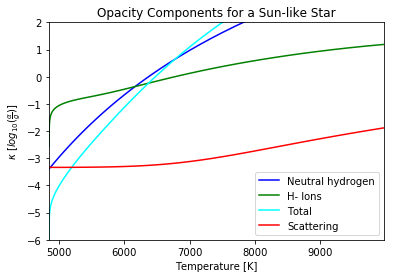

In [176]:
#Plotting opacity values for a sun-like star
plt.plot(temp, kappa_atomic, color = 'blue', label = 'Neutral hydrogen')
plt.plot(temp, kappa_ion, color = 'green', label = 'H- Ions')
plt.plot(temp, kappa_total, color = 'cyan', label = 'Total')
plt.plot(temp, np.log10(sigma_total), color = 'red', label = 'Scattering')
plt.xlim(np.min(temp), np.max(temp))
plt.ylim(-6, 2)
plt.legend(loc=4, prop={'size':10})
plt.xlabel('Temperature [K]')
plt.ylabel(r'$\kappa \,\, [log_{10}(\frac{\alpha}{g})]$')
plt.title('Opacity Components for a Sun-like Star')
plt.savefig('Sun_opacity.png')

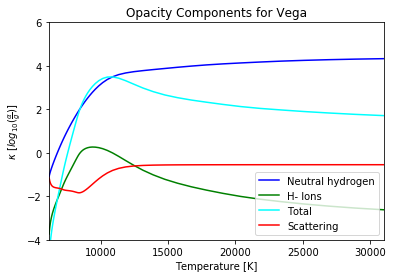

In [177]:
#Plotting opacity values for Vega
plt.plot(temp_vega, kappa_atomic_vega, color = 'blue', label = 'Neutral hydrogen')
plt.plot(temp_vega, kappa_ion_vega, color = 'green', label = 'H- Ions')
plt.plot(temp_vega, kappa_total_vega, color = 'cyan', label = 'Total')
plt.plot(temp_vega, np.log10(sigma_total_vega), color = 'red', label = 'Scattering')
plt.xlim(np.min(temp_vega), np.max(temp_vega))
plt.ylim(-4, 6)
plt.legend(loc=4, prop={'size':10})
plt.xlabel('Temperature [K]')
plt.ylabel(r'$\kappa \,\, [log_{10}(\frac{\alpha}{g})]$')
plt.title('Opacity Components for Vega')
plt.savefig('Vega_opacity.png')

Your neutral H values are off by  1.581743517
Your H- values are off by  -0.0208599034489
Your sigma values are off by  -1.11636823467e-07


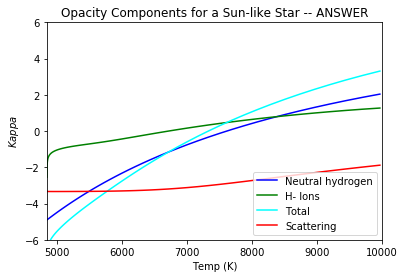

In [178]:
#Plotting official results
plt.plot(temp, check_H, color = 'blue', label = 'Neutral hydrogen')
plt.plot(temp, check_Hminus, color = 'green', label = 'H- Ions')
plt.plot(temp, check_H + check_Hminus, color = 'cyan', label = 'Total')
plt.plot(temp, check_sigma, color = 'red', label = 'Scattering')
plt.xlim(np.min(temp), 10000)
plt.ylim(-6, 6)
plt.legend(loc=4, prop={'size':10})
plt.xlabel('Temp (K)')
plt.ylabel(r'$Kappa $')
plt.title('Opacity Components for a Sun-like Star -- ANSWER')
delta_H = kappa_atomic - check_H
delta_Hion = kappa_ion - check_Hminus
delta_sigma = np.log10(sigma_total) - check_sigma

#Check average change in H values, they are off by about this much
print 'Your neutral H values are off by ', np.sum(delta_H)/len(delta_H)
print 'Your H- values are off by ', np.sum(delta_Hion)/len(delta_Hion)
print 'Your sigma values are off by ', np.sum(delta_sigma)/len(delta_sigma)